Feature Matrix Shape: (158, 460)
Trained 5 models with bagging.
Accuracy: 0.8333
Log Loss: 0.6909
Accuracy: 0.8333
Log Loss: 0.6909
Confusion Matrix:
[[9 0 0 0 0 0 0 0 0 0 0 0]
 [0 9 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 1 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 2 0 0 0 0 0 0]
 [1 0 0 0 0 0 3 0 0 0 0 0]
 [1 0 0 0 0 0 0 3 0 1 0 0]
 [0 0 0 0 0 0 1 0 2 0 0 0]
 [0 0 0 0 0 0 0 0 1 2 0 0]
 [0 0 0 0 1 1 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 5]]

Classification Report:
                    precision    recall  f1-score   support

     BRONZE BUTLER       0.82      1.00      0.90         9
      Dark Caracal       1.00      1.00      1.00         9
         ELDERWOOD       1.00      0.50      0.67         2
           EVILNUM       1.00      1.00      1.00         1
           GALLIUM       0.67      1.00      0.80         2
             GCMAN       0.67      1.00      0.80         2
          KE3CHANG       0.75      0.75      0.75         4
          MENUPASS  

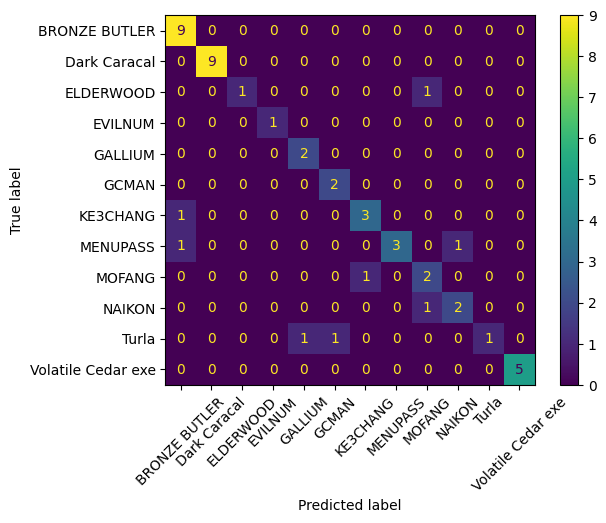

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix, ConfusionMatrixDisplay,classification_report
from xgboost import XGBClassifier
from collections import Counter
from sklearn.utils import resample

# Extract opcode frequencies for all opcodes
def extract_opcode_frequencies_all(opcodes):
    vocabulary = Counter()
    for sample in opcodes:
        vocabulary.update(sample.split())
    sorted_vocab = sorted(vocabulary.keys())

    feature_matrix = []
    for sample in opcodes:
        counts = Counter(sample.split())
        feature_vector = [counts.get(opcode, 0) for opcode in sorted_vocab]
        feature_matrix.append(feature_vector)
    return np.array(feature_matrix), sorted_vocab

# Calculate entropy of opcode sequences
def calculate_entropy(opcodes):
    def shannon_entropy(sequence):
        probabilities = np.array(list(Counter(sequence).values())) / len(sequence)
        return -np.sum(probabilities * np.log2(probabilities))

    entropies = []
    for sample in opcodes:
        sequence = sample.split()
        entropies.append(shannon_entropy(sequence))
    return np.array(entropies).reshape(-1, 1)

# Train model with bagging
def train_with_bagging(X, y, n_estimators=10):
    models = []
    for i in range(n_estimators):
        X_resampled, y_resampled = resample(X, y, random_state=i, replace=True)

        # Ensure all classes are present
        missing_classes = set(np.unique(y)) - set(np.unique(y_resampled))
        if missing_classes:
            for missing_class in missing_classes:
                idx = np.where(y == missing_class)[0][0]
                X_resampled = np.vstack([X_resampled, X[idx]])
                y_resampled = np.append(y_resampled, y[idx])

        # Train XGBoost model
        model = XGBClassifier(eval_metric="logloss", max_depth=5, subsample=0.8, colsample_bytree=0.8)
        model.fit(X_resampled, y_resampled)
        models.append(model)
    return models

# Aggregate predictions
def aggregate_predictions(models, X):
    all_probs = np.zeros((X.shape[0], len(models[0].classes_)))
    for model in models:
        all_probs += model.predict_proba(X)
    averaged_probs = all_probs / len(models)
    averaged_probs = averaged_probs / np.sum(averaged_probs, axis=1, keepdims=True)
    return np.argmax(averaged_probs, axis=1), averaged_probs

# Classification pipeline with bagging
def train_xgboost(file_path, n_estimators=5):
    # Load dataset
    df = pd.read_csv(file_path)
    
    # Remove rare classes
    class_counts = df['APT'].value_counts()
    rare_classes = class_counts[class_counts < 5].index
    df = df[~df['APT'].isin(rare_classes)]

    # Extract opcode-based features
    opcodes = df['Opcodes']
    opcode_features, _ = extract_opcode_frequencies_all(opcodes)
    entropy_features = calculate_entropy(opcodes)
    
    # Combine features
    X = np.hstack([opcode_features, entropy_features])
    print(f"Feature Matrix Shape: {X.shape}")

    # Normalize features
    scaler = MinMaxScaler()
    X_normalized = scaler.fit_transform(X)

    # Encode labels
    y = df['APT']
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    # Stratified train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_normalized, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
    )

    # Train with bagging
    models = train_with_bagging(X_train, y_train, n_estimators=n_estimators)
    print(f"Trained {len(models)} models with bagging.")

    # Aggregate predictions
    y_pred, y_prob = aggregate_predictions(models, X_test)

    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    log_loss_val = log_loss(y_test, y_prob)
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Log Loss: {log_loss_val:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
    disp.plot(cmap="viridis", xticks_rotation=45)

    print("Confusion Matrix:")
    print(cm)

    # Classification Report
    class_report = classification_report(y_test, y_pred, target_names=label_encoder.classes_, output_dict=True)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

    # Weighted averages for precision, recall, F1-score
    precision_weighted = class_report['weighted avg']['precision']
    recall_weighted = class_report['weighted avg']['recall']
    f1_weighted = class_report['weighted avg']['f1-score']

    print(f"Weighted Average Precision: {precision_weighted:.4f}")
    print(f"Weighted Average Recall: {recall_weighted:.4f}")
    print(f"Weighted Average F1-Score: {f1_weighted:.4f}")

    # Decode predictions
    decoded_predictions = label_encoder.inverse_transform(y_pred)
    print("Sample Predictions (Decoded):", decoded_predictions[:5])

file_path = ".\\output_opcodes.csv" 
train_xgboost(file_path)
